In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as it
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score,train_test_split,cross_val_predict,cross_validate
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, \
accuracy_score, precision_score, confusion_matrix, mean_squared_error, r2_score, mean_absolute_error
from sklearn import impute

import warnings
warnings.filterwarnings("ignore")

In [ ]:
train = pd.read_csv('train_clean.csv')
test = pd.read_csv('test_clean.csv')
train = train.drop('Unnamed: 0',axis=1)
test = test.drop('Unnamed: 0',axis=1)

In [ ]:
# Separating the predictors and response
y_train = train.target
X_train = train.drop('target',axis =1)
y_test = test.target
X_test = test.drop('target',axis=1)

# AdaBoost

In [ ]:
#AdaBoost model with default parameters
ada_default_model = AdaBoostClassifier(random_state=1).fit(X_train,y_train)

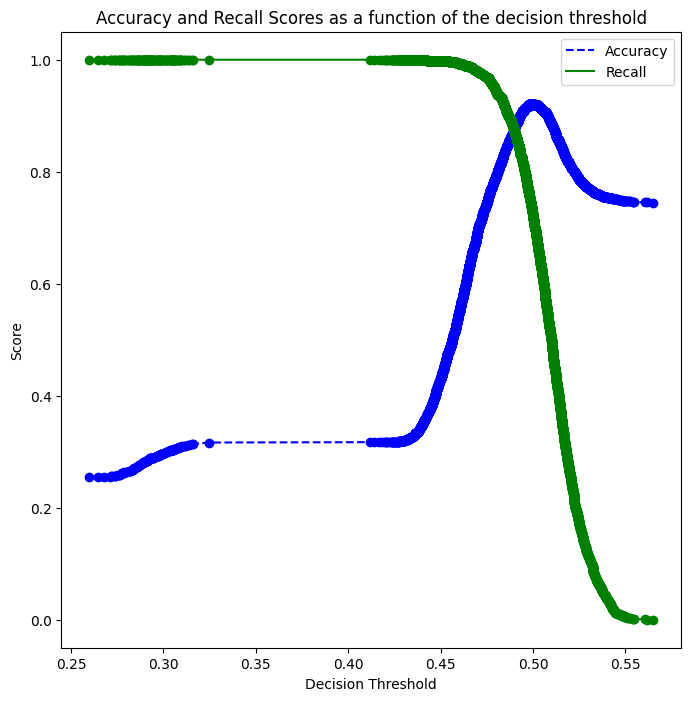

In [ ]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(ada_default_model, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred_prob = ada_default_model.predict_proba(X_train)[:,1] 
    y_pred = y_pred_prob > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [ ]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]

array([0.49188075, 0.65371876, 0.85037211])

In [ ]:
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.49188074949657634

Test Accuracy:  83.38
Train Accuracy:  89.12
ROC-AUC Test:  0.8921205271425563
ROC-AUC Train:  0.9753976803620372
Test Precision:  0.6684751570531126
Train Precision:  0.7156314395054459
Test Recall:  0.8237156931738212
Train Recall:  0.9522130826478653


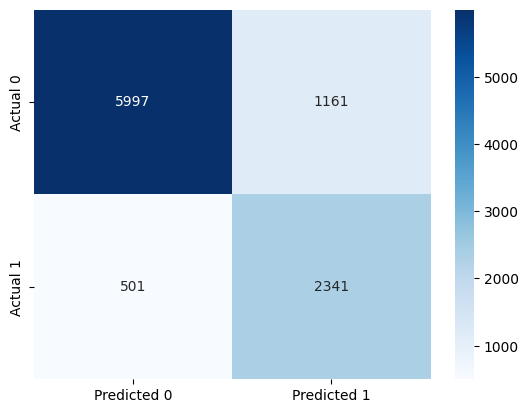

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = ada_default_model.predict_proba(X_test)[:,1] 
y_pred_prob_train = ada_default_model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [ ]:
#Coarse grid search
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [10, 50, 100,200,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2), 
                          DecisionTreeClassifier(max_depth=3),DecisionTreeClassifier(max_depth=4)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# define the grid search procedure
grid_result = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, 
                          verbose = True).fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best: 0.979200 using {'n_estimators': 500, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.879100 (0.006280) with: {'n_estimators': 500, 'learning_rate': 0.0001, 'base_estimator': DecisionTreeClassifier(max_depth=4)}
0.952200 (0.002561) with: {'n_estimators': 500, 'learning_rate': 0.01, 'base_estimator': DecisionTreeClassifier(max_depth=4)}
0.904200 (0.002015) with: {'n_estimators': 10, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=4)}
0.884900 (0.004630) with: {'n_estimators': 50, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=1)}
0.979200 (0.000400) with: {'n_estimators': 500, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.865200 (0.004643) with: {'n_estimators': 100, 'learning_rate': 0.001, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.974400 (0.001625) with: {'n_estimators': 200, 'learning_rate': 

In [ ]:
#Coarse grid model
ada_model_1 = AdaBoostClassifier(random_state=1, n_estimators=500, learning_rate=0.1, base_estimator=DecisionTreeClassifier(max_depth=3)).fit(X_train,y_train)

In [ ]:
importances_df = pd.DataFrame({'Features': X_train.columns,'Importances':ada_model_1.feature_importances_})
importances_df.sort_values(by='Importances',ascending=False, inplace=True)
importances_df

,Features,Importances
15,D_47,4.979712e-02
20,D_50,4.115380e-02
0,P_2,3.765362e-02
24,D_52,3.131383e-02
146,D_124,2.977735e-02
...,...,...
32,R_4,3.050073e-05
95,S_18,2.153471e-07
71,R_7,0.000000e+00
70,B_24,0.000000e+00


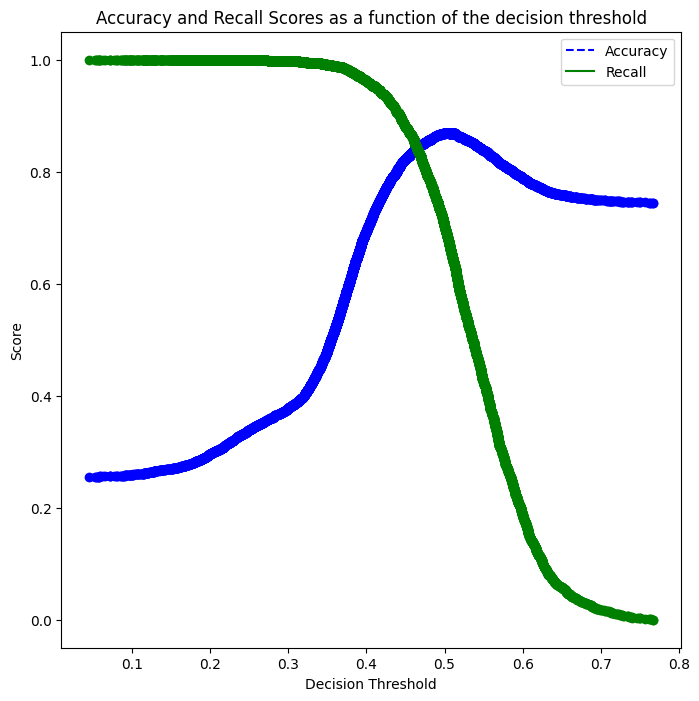

In [ ]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(ada_model_1, X_train, y_train, cv = 3, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [ ]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.4618290585493649

Test Accuracy:  81.73
Train Accuracy:  94.69999999999999
ROC-AUC Test:  0.8945533990108459
ROC-AUC Train:  1.0
Test Precision:  0.6338696913743076
Train Precision:  0.8280895231916964
Test Recall:  0.8455313159746657
Train Recall:  1.0


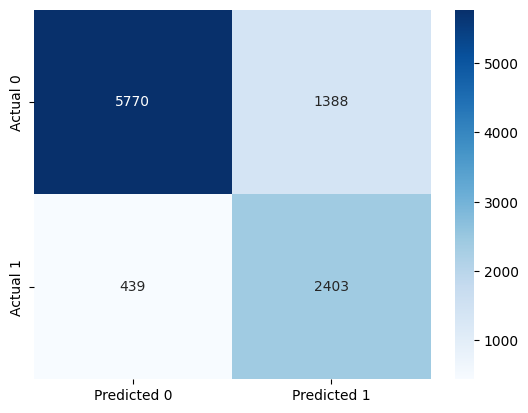

In [ ]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = ada_model_1.predict_proba(X_test)[:,1] 
y_pred_prob_train = ada_model_1.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

>10 0.869 (0.007)
>50 0.908 (0.010)
>100 0.922 (0.009)
>200 0.938 (0.006)
>500 0.948 (0.006)


Text(0.5, 0, 'Number of trees')

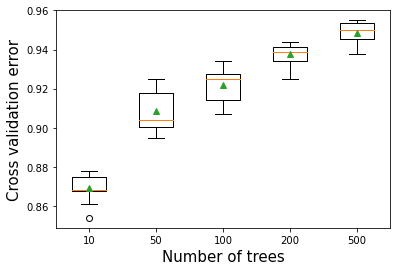

In [ ]:
# number of trees vs. cross validation accuracy
def get_models():
    models = dict()
    # define number of trees to consider
    n_trees = [10, 50, 100,200,500]
    for n in n_trees:
        models[str(n)] = AdaBoostClassifier(n_estimators=n,random_state=1)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Cross validation error',fontsize=15)
plt.xlabel('Number of trees',fontsize=15)

>1 0.908 (0.010)
>2 0.945 (0.007)
>3 0.967 (0.006)
>4 0.963 (0.005)
>5 0.955 (0.006)
>6 0.946 (0.008)
>7 0.937 (0.008)
>8 0.935 (0.006)
>9 0.933 (0.008)
>10 0.937 (0.007)
>11 0.938 (0.008)
>12 0.946 (0.006)
>13 0.946 (0.003)
>14 0.941 (0.007)
>15 0.948 (0.006)
>16 0.951 (0.007)
>17 0.954 (0.007)
>18 0.953 (0.008)
>19 0.958 (0.005)
>20 0.956 (0.008)


Text(0.5, 0, 'Depth of each tree')

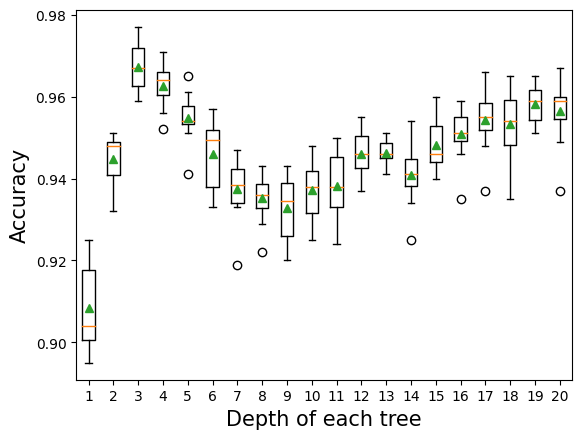

In [9]:
# get a list of models to evaluate
def get_models():
    models = dict()
    # explore depths from 1 to 10
    for i in range(1,21):
        # define base model
        base = DecisionTreeClassifier(max_depth=i)
        # define ensemble model
        models[str(i)] = AdaBoostClassifier(base_estimator=base)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X_train, y_train)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Depth of each tree',fontsize=15)

In [ ]:
def get_models():
    models = dict()
    # explore learning rates from 0.1 to 2 in 0.1 increments
    for i in np.arange(0.1, 2.1, 0.1):
        key = '%.1f' % i
        models[key] = AdaBoostClassifier(learning_rate=i)
    return models

# evaluate a given model using cross-validation
def evaluate_model(model, X_train, y_train):
    # define the evaluation procedure
    cv = KFold(n_splits=10, shuffle=True, random_state=1)
    # evaluate the model and collect the results
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    # evaluate the model
    scores = evaluate_model(model, X, y)
    # store the results
    results.append(scores)
    names.append(name)
    # summarize the performance along the way
    print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))
# plot model performance for comparison
plt.figure(figsize=(7, 7))
plt.boxplot(results, labels=names, showmeans=True)
plt.ylabel('Accuracy',fontsize=15)
plt.xlabel('Learning rate',fontsize=15)

In [10]:
# Fine grid search
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [450,500,600,700]
grid['learning_rate'] = [0.05, 0.1, 0.2, 0.3]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3),
                          DecisionTreeClassifier(max_depth=4), DecisionTreeClassifier(max_depth=5)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# define the grid search procedure
grid_result = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, 
                          verbose = True).fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best: 0.967800 using {'n_estimators': 600, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.967800 (0.000000) with: {'n_estimators': 600, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.966100 (0.003500) with: {'n_estimators': 600, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=4)}
0.964000 (0.002400) with: {'n_estimators': 600, 'learning_rate': 0.05, 'base_estimator': DecisionTreeClassifier(max_depth=5)}
0.962100 (0.000100) with: {'n_estimators': 700, 'learning_rate': 0.1, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.959300 (0.007300) with: {'n_estimators': 500, 'learning_rate': 0.3, 'base_estimator': DecisionTreeClassifier(max_depth=5)}
0.964200 (0.003000) with: {'n_estimators': 500, 'learning_rate': 0.3, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.963800 (0.002400) with: {'n_estimators': 450, 'learning_rate': 0.2

In [11]:
#fine grid model
ada_model_2 = AdaBoostClassifier(random_state=1, n_estimators=600, learning_rate=0.2, base_estimator=DecisionTreeClassifier(max_depth=3)).fit(X_train,y_train)

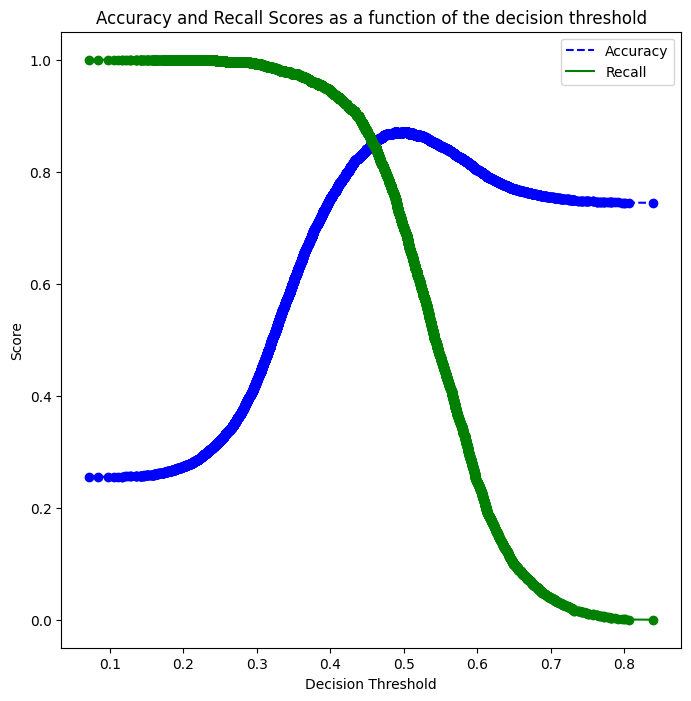

In [13]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(ada_model_2, X_train, y_train, cv = 2, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [15]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.4578195311348837

Test Accuracy:  78.25999999999999
Train Accuracy:  92.67999999999999
ROC-AUC Test:  0.8911401916606745
ROC-AUC Train:  1.0
Test Precision:  0.5762905436272271
Train Precision:  0.7771689497716895
Test Recall:  0.8877551020408163
Train Recall:  1.0


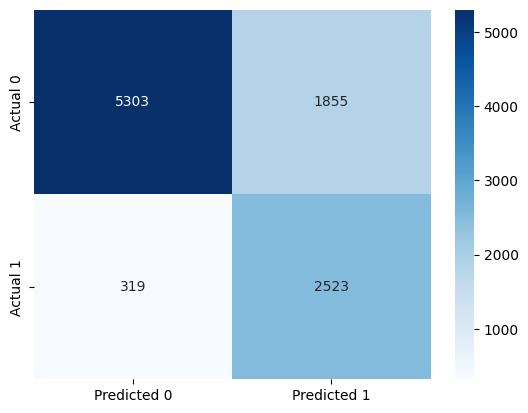

In [16]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = ada_model_2.predict_proba(X_test)[:,1] 
y_pred_prob_train = ada_model_2.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [17]:
# Fine grid search
model = AdaBoostClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [550,600,650]
grid['learning_rate'] = [0.15, 0.2, 0.25]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# define the grid search procedure
grid_result = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, 
                          verbose = True).fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 9 candidates, totalling 18 fits
Best: 0.967800 using {'n_estimators': 600, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.960400 (0.001800) with: {'n_estimators': 550, 'learning_rate': 0.15, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.960500 (0.002100) with: {'n_estimators': 600, 'learning_rate': 0.15, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.961700 (0.002700) with: {'n_estimators': 650, 'learning_rate': 0.15, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.966200 (0.000800) with: {'n_estimators': 550, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.967800 (0.000000) with: {'n_estimators': 600, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.967700 (0.001500) with: {'n_estimators': 650, 'learning_rate': 0.2, 'base_estimator': DecisionTreeClassifier(max_depth=3)}
0.964500 (0.001300) with: {'n_estimators': 550, 'learning_rate': 0.

In [18]:
#fine grid model
ada_model_3 = AdaBoostClassifier(random_state=1, n_estimators=600, learning_rate=0.2, base_estimator=DecisionTreeClassifier(max_depth=3)).fit(X_train,y_train)

In [32]:
# Fine grid search with GridSearch
model = AdaBoostClassifier(random_state=1)
grid = dict()
# grid['n_estimators'] = [550,600,650]
grid['learning_rate'] = [0.15, 0.2, 0.25, 0.3]
grid['base_estimator'] = [DecisionTreeClassifier(max_depth=3), DecisionTreeClassifier(max_depth=4)]

# define the evaluation procedure
cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=1)

# define the grid search procedure
grid_result = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, 
                          verbose = True).fit(X_train, y_train)

# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 2 folds for each of 8 candidates, totalling 16 fits
Best: 0.948100 using {'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.25}
0.931200 (0.002000) with: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.15}
0.939400 (0.005400) with: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.2}
0.937700 (0.002500) with: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.25}
0.945300 (0.001700) with: {'base_estimator': DecisionTreeClassifier(max_depth=3), 'learning_rate': 0.3}
0.936700 (0.001900) with: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.15}
0.946200 (0.005600) with: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.2}
0.948100 (0.004500) with: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.25}
0.942400 (0.002600) with: {'base_estimator': DecisionTreeClassifier(max_depth=4), 'learning_rate': 0.3}


In [33]:
ada_model_4 = AdaBoostClassifier(random_state=1, n_estimators=600, learning_rate=0.25, base_estimator=DecisionTreeClassifier(max_depth=4)).fit(X_train,y_train)

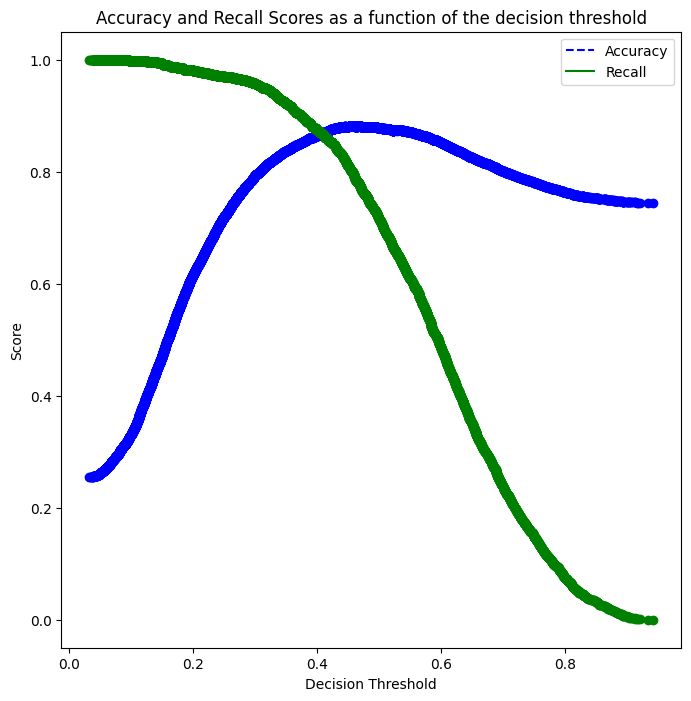

In [34]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(ada_model_4, X_train, y_train, cv = 2, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [35]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.42504488133455015

Test Accuracy:  84.11
Train Accuracy:  100.0
ROC-AUC Test:  0.9126680501376492
ROC-AUC Train:  1.0
Test Precision:  0.6716908742121129
Train Precision:  1.0
Test Recall:  0.8624208304011259
Train Recall:  1.0


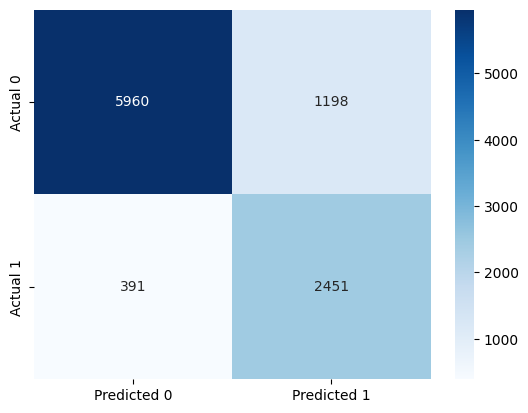

In [47]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = 0.44

y_pred_prob_test = ada_model_4.predict_proba(X_test)[:,1] 
y_pred_prob_train = ada_model_4.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# Gradient Bosting

In [25]:
#Default gradient boosting model
grad_default_model = GradientBoostingClassifier(random_state=1).fit(X_train,y_train)

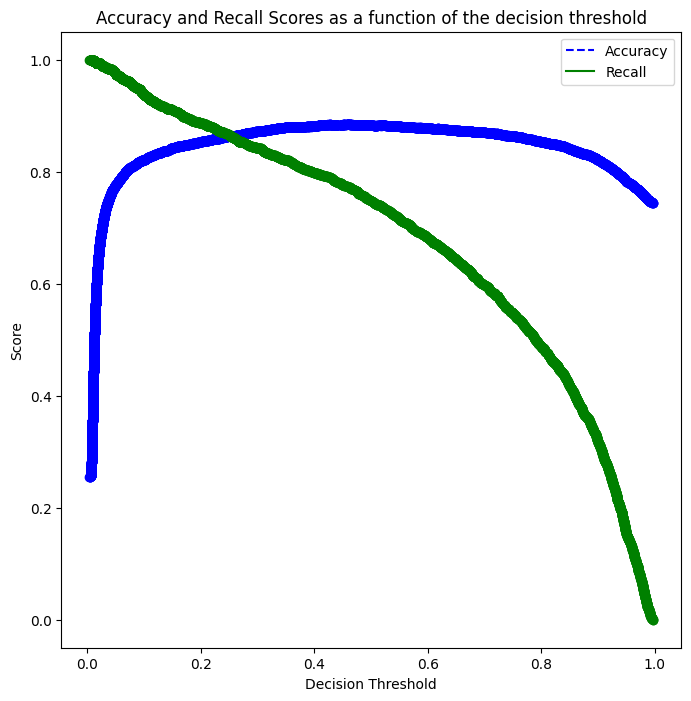

In [26]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(grad_default_model, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [28]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.2796732116513854

Test Accuracy:  85.61
Train Accuracy:  94.38
ROC-AUC Test:  0.9242279274342334
ROC-AUC Train:  0.9911980686497417
Test Precision:  0.7136765153822723
Train Precision:  0.8343970440040309
Test Recall:  0.8244194229415904
Train Recall:  0.972972972972973


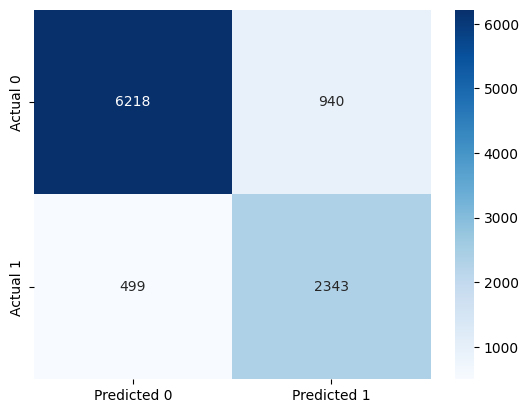

In [29]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = grad_default_model.predict_proba(X_test)[:,1] 
y_pred_prob_train = grad_default_model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [30]:
# Coarse grid search
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [100,300,500]
grid['learning_rate'] = [0.0001, 0.001, 0.01,0.1, 1.0]
grid['max_depth'] = [2,4,8]
grid['subsample'] = [0.5,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best: 0.922836 using {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 8, 'learning_rate': 0.01}


In [31]:
#Coarse model
grad_model_1 = GradientBoostingClassifier(random_state=1, max_depth=8,n_estimators=500,learning_rate=0.1,
                                          subsample=1.0).fit(X_train,y_train)

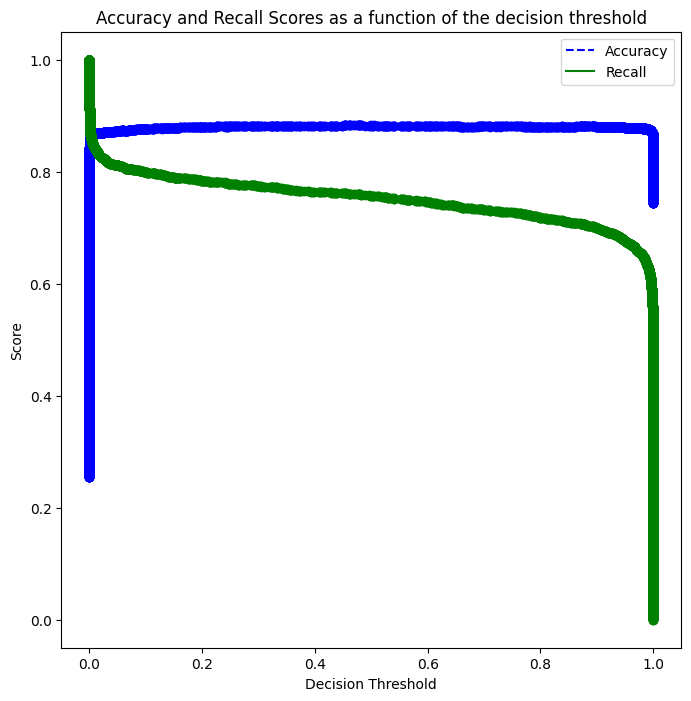

In [37]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(grad_model_1, X_train, y_train, cv = 3, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [38]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.00569153542086154

Test Accuracy:  85.54
Train Accuracy:  100.0
ROC-AUC Test:  0.9226144022947214
ROC-AUC Train:  1.0
Test Precision:  0.712287104622871
Train Precision:  1.0
Test Recall:  0.8240675580577058
Train Recall:  1.0


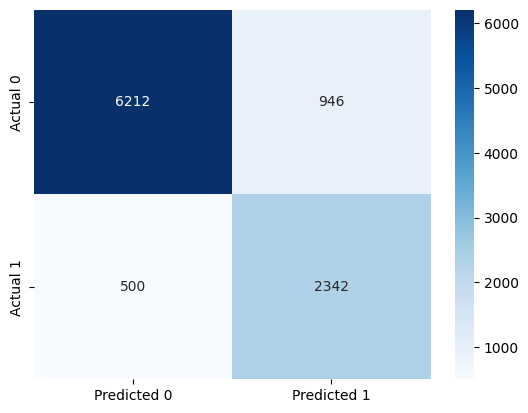

In [39]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = grad_model_1.predict_proba(X_test)[:,1] 
y_pred_prob_train = grad_model_1.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [19]:
# Fine grid search
model = GradientBoostingClassifier(random_state=1)
grid = dict()
grid['n_estimators'] = [400,500,600]
grid['learning_rate'] = [0.05,0.1, 0.2]
grid['max_depth'] = [7,8,9]
grid['subsample'] = [0.75,0.9,1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best: 0.969448 using {'subsample': 1.0, 'n_estimators': 600, 'max_depth': 7, 'learning_rate': 0.1}


In [20]:
#Fine model
grad_model_2 = GradientBoostingClassifier(random_state=1, max_depth=7,n_estimators=600,learning_rate=0.1,
                         subsample=1.0).fit(X_train,y_train)

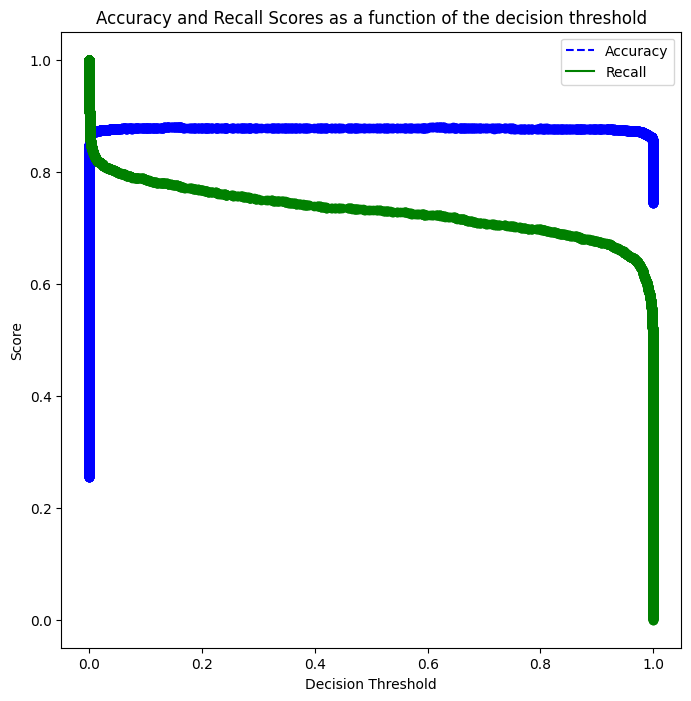

In [22]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(grad_model_2, X_train, y_train, cv = 2, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [23]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.002491218457306811

Test Accuracy:  85.07000000000001
Train Accuracy:  100.0
ROC-AUC Test:  0.9220256012917639
ROC-AUC Train:  1.0
Test Precision:  0.692329626461363
Train Precision:  1.0
Test Recall:  0.8543279380717804
Train Recall:  1.0


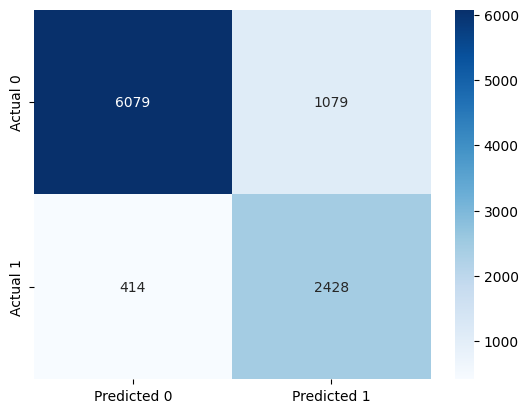

In [24]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = grad_model_2.predict_proba(X_test)[:,1] 
y_pred_prob_train = grad_model_2.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

In [48]:
# Fine grid search
model = GradientBoostingClassifier(random_state=1)
grid = dict()
# grid['n_estimators'] = [400,500,600]
grid['learning_rate'] = [0.07,0.1, 0.15]
grid['max_depth'] = [7,8,9]
grid['subsample'] = [1.0]
# define the evaluation procedure
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)
# define the grid search procedure
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, verbose = True, scoring = 'recall')
# execute the grid search
grid_result = grid_search.fit(X_train, y_train)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 9 candidates, totalling 27 fits
Best: 0.950646 using {'learning_rate': 0.15, 'max_depth': 7, 'subsample': 1.0}


In [49]:
#Fine model
grad_model_3 = GradientBoostingClassifier(random_state=1, max_depth=7,n_estimators=600,learning_rate=0.15,
                         subsample=1.0).fit(X_train,y_train)

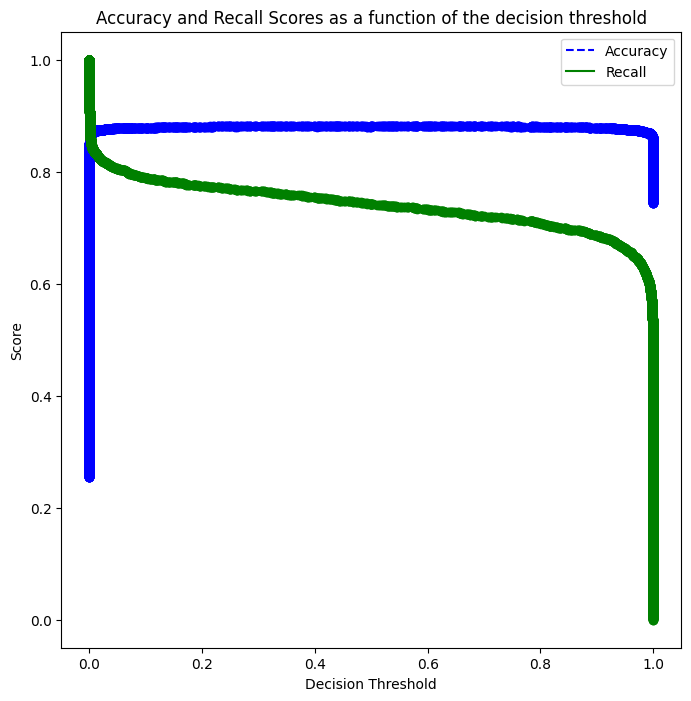

In [50]:
#tune decision threshold probability
cross_val_ypred = cross_val_predict(grad_model_3, X_train, y_train, cv = 2, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
accuracy_list = []
for t in thresholds: 
    y_pred = cross_val_ypred[:,1] > t
    y_pred = y_pred.astype(int)
    accuracy = (accuracy_score(y_pred, y_train))
    accuracy_list.append(accuracy)
def plot_accuracy_recall_vs_threshold(accuracy, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Accuracy and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, accuracy_list, "b--", label="Accuracy")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, accuracy_list, "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_accuracy_recall_vs_threshold(accuracy_list, r, thresholds)

In [51]:
# Thresholds with accuracy and recall
all_thresholds = np.concatenate([thresholds.reshape(-1,1), p[:-1].reshape(-1,1), r[:-1].reshape(-1,1)], axis = 1)
recall_more_than_85 = all_thresholds[all_thresholds[:,2]>0.85,:]
# As the values in 'recall_more_than_85' are arranged in decreasing order of recall and increasing threshold,
# the last value will provide the maximum threshold probability for the recall to be more than 80%
# We wish to find the maximum threshold probability to obtain the maximum possible precision
recall_more_than_85[recall_more_than_85.shape[0]-1]
#Optimal decision threshold probability
thres = recall_more_than_85[recall_more_than_85.shape[0]-1][0]
thres

0.0031014111400233055

Test Accuracy:  85.6
Train Accuracy:  100.0
ROC-AUC Test:  0.9184467844425974
ROC-AUC Train:  1.0
Test Precision:  0.717296962182269
Train Precision:  1.0
Test Recall:  0.8142153413089374
Train Recall:  1.0


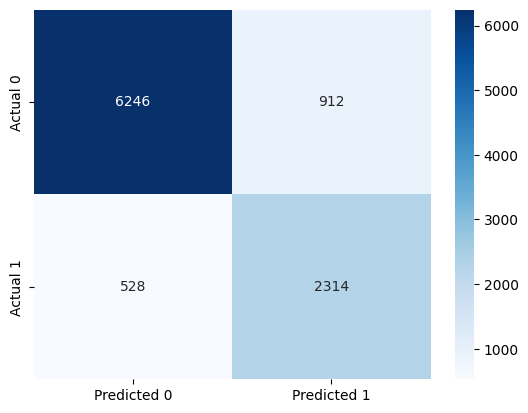

In [52]:
# Performance metrics computation for the optimum decision threshold probability
desired_threshold = thres

y_pred_prob_test = grad_model_3.predict_proba(X_test)[:,1] 
y_pred_prob_train = grad_model_3.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred_test = y_pred_prob_test > desired_threshold
y_pred_test = y_pred_test.astype(int)

y_pred_train = y_pred_prob_train > desired_threshold
y_pred_train = y_pred_train.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred_test, y_test)*100)
print("Train Accuracy: ",accuracy_score(y_pred_train, y_train)*100) 

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob_test)
print("ROC-AUC Test: ",auc(fpr, tpr))# AUC of ROC

fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob_train)
print("ROC-AUC Train: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred_test))
print("Train Precision: ", precision_score(y_train, y_pred_train))
print("Test Recall: ", recall_score(y_test, y_pred_test))
print("Train Recall: ", recall_score(y_train, y_pred_train))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred_test), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');